In [ ]:
%matplotlib inline

## Tweedie regresion on insurance claims

### Optimal power parameter for the total loss model


In [67]:
print(__doc__)

# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
# License: BSD 3 clause
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_absolute_error, mean_squared_error, auc


def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """

    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(np.int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == np.object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]

Automatically created module for IPython interactive environment


1. Loading datasets and pre-processing
--------------------------------------

We construct the freMTPL2 dataset by joining the freMTPL2freq table,
containing the number of claims (``ClaimNb``), with the freMTPL2sev table,
containing the claim amount (``ClaimAmount``) for the same policy ids
(``IDpol``).



In [66]:
df = load_mtpl2(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)


df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

print(df[df.ClaimAmount > 0].head())

/home/rth/src/scikit-learn/sklearn/datasets/openml.py:655: UserWarning: Version 1 of dataset freMTPL2freq is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649148/freMTPL2freq.arff
  data_description['url']))
/home/rth/src/scikit-learn/sklearn/datasets/openml.py:655: UserWarning: Version 1 of dataset freMTPL2sev is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649149/freMTPL2sev.arff
  data_description['url']))


       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139        1.0      0.75    F       7.0     1.0     61.0        50.0      B12   
190        1.0      0.14    B      12.0     5.0     50.0        60.0      B12   
414        1.0      0.14    E       4.0     0.0     36.0        85.0      B12   
424        2.0      0.62    F      10.0     0.0     51.0       100.0      B12   
463        1.0      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount  Frequency  AvgClaimAmount  
IDpol                                                                   
139    Regular  27000.0    R11       303.00   1.333333          303.00  
190     Diesel     56.0    R25      1981.84   7.142857         1981.84  
414    Regular   4792.0    R11      1456.55   7.142857         1456.55  
424    Regular  27000.0    R11     10834.00   3.225806         5417

/home/rth/src/scikit-learn/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


4. Total claim amount -- Compound Poisson Gamma distribution
------------------------------------------------------------

As mentioned in the introduction, the total claim amount can be modeled
either as the product of the frequency model by the severity model,
denormalized by exposure. In the following code sample, the
``score_estimator`` is extended to score such a model. The mean deviance is
computed assuming a Tweedie distribution with ``power=2`` to be comparable
with the model from the following section:



Instead of taking the product of two independently fit models for frequency
and severity one can directly model the total loss is with a unique Compound
Poisson Gamma generalized linear model (with a log link function). This
model is a special case of the Tweedie model with a power parameter $p
\in (1, 2)$.

We determine the optimal hyperparameter ``p`` with a grid search so as to
minimize the deviance:



In [68]:
def parse_cv_results(results):
    df = pd.DataFrame({'test_score_mean': results['mean_test_score'],
                       'test_score_std': results['std_test_score'],
                       'power': np.asarray(results["param_power"])})
    return df

from sklearn._loss.glm_distribution import TweedieDistribution
from sklearn.metrics import make_scorer
from sklearn.utils.validation import _check_sample_weight

def d2_score(y_true, y_pred, sample_weight=None, power=0):
    weights = _check_sample_weight(sample_weight, y_true)
    family = TweedieDistribution(power=power)
    dev = family.deviance(y_true, y_pred, weights=weights)
    y_mean = np.average(y_true, weights=weights)
    dev_null = family.deviance(y_true, y_mean, weights=weights)
    return 1 - dev / dev_null



In [84]:
# exclude upper bound as power>=2 as p=2 would lead to an undefined unit
# deviance on data points with y=0.
params = {"power": np.concatenate(([0], np.linspace(1 + eps, 2 - eps, 10)))}

def plot_optimal_power_param(alpha=1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
    
    y_min = 1e10
    y_max = -1e10
    
    for label, scoring,  in [
        ("p dependent", None),
        ("p=0.0", make_scorer(d2_score, power=0.0)),
        ("p=1.0", make_scorer(d2_score, power=1.0)),
        ("p=1.5", make_scorer(d2_score, power=1.5)),
        ("p=2.0", make_scorer(d2_score, power=1.999999)),
    ]:
    
    
        glm_total = TweedieRegressor(max_iter=10000, alpha=alpha)
        search = GridSearchCV(
            glm_total, cv=5,
            param_grid=params, n_jobs=-1, verbose=1,
            refit=False,
            scoring=scoring
        )
        search.fit(
            X_train_small, df_train_small["ClaimAmount"],
            sample_weight=df_train_small["Exposure"]
        )
    
    
        df = parse_cv_results(search.cv_results_)
    
    
        df.plot(x='power', y="test_score_mean", yerr="test_score_std", marker="o",
                ax=ax, label=label, alpha=0.8)
        ax.set_ylabel('D² score')
        y_min = min(y_min, np.nanmin(df['test_score_mean']))
        y_max = max(y_min, np.nanmax(df['test_score_mean']))
        
    ax.set_title(f'Optimal power paramer for different scorers, alpha={alpha:.2f}')
    #ax.set_ylim(-0.4, 0.2)
    ax.set_ylim(y_min - 0.05, y_max + 0.05)
    ax.grid(which="both")

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished


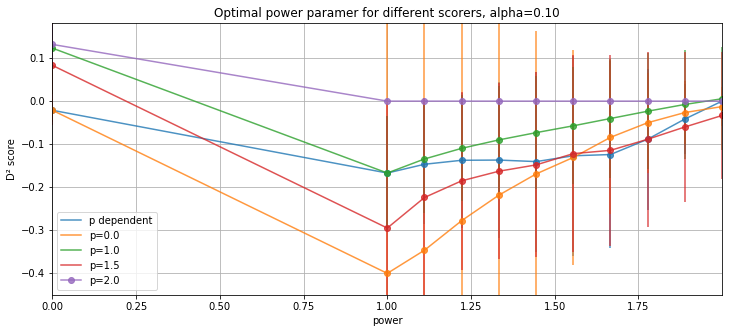

In [85]:
plot_optimal_power_param(alpha=0.1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished


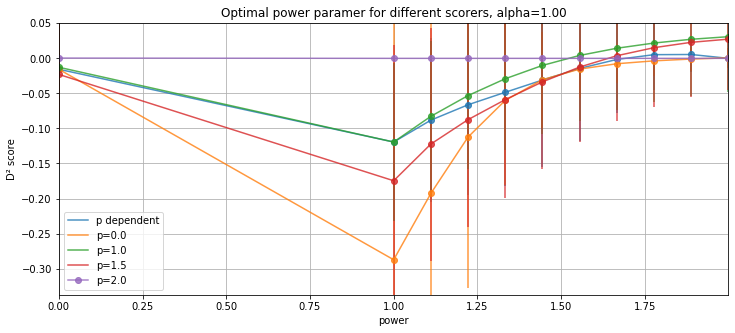

In [86]:
plot_optimal_power_param(alpha=1.0)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.1s remaining:    0.8s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.1s remaining:    0.9s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.2s remaining:    0.9s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    0.1s remaining:    0.8s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished


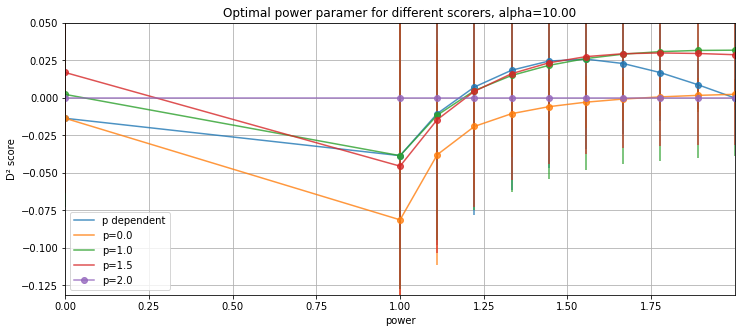

In [87]:
plot_optimal_power_param(alpha=10)